# probabilistic programming (in `numpyro`) 

In [1]:
from functools import reduce, partial

import jax.numpy as jnp
from jax import random, vmap, grad

import arviz as az
from matplotlib import pyplot as plt
from ipywidgets.widgets import FloatSlider
from ipywidgets import interact
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde, zscore

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, NUTS, MCMC
from numpyro.infer.autoguide import AutoLaplaceApproximation

import pandas as pd

from clean import Clean

key = random.PRNGKey(0)

In [2]:
clean = Clean("data/10-22-2021-sample-data.csv", abso=False)
df = clean.df
df.head()

,A,D,B0,B1,B2,Root,Y,newton_delta,squared_newton_delta
0,2.067659,2.243548e+11,1.475697e+11,8.032713e+10,6.558503e+10,2.924764e+11,1.373189e+34,-6.812162e+10,4.640556e+21
1,1.073261,2.626122e+11,4.022874e+09,2.176361e+09,3.527153e+10,3.586240e+10,-6.780080e+32,2.267498e+11,5.141547e+22
2,2.259081,7.061592e+10,1.231400e+11,1.013308e+10,1.199092e+09,9.825665e+10,7.098000e+31,-2.764073e+10,7.640097e+20
3,2.207330,1.894204e+11,4.743854e+10,1.564121e+11,1.838070e+11,3.841779e+11,8.617764e+34,-1.947575e+11,3.793050e+22
4,1.776335,4.577537e+11,1.195981e+10,1.628059e+11,2.445517e+11,3.899494e+11,-4.993929e+33,6.780430e+10,4.597423e+21


In [3]:
product = partial(reduce, lambda x,y: x * y)
def _invariant(A: float, D: float, *balances: list) -> float:
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        D ** (n + 1) 
        + 
        (A - n ** (- n)) * n_raised_2n * product(balances) * D 
        + 
        (- A * n_raised_2n * product(balances) * sum(balances))
    )

def _invariant_dmnlynormd_1(A: float, D: float, *balances: list) -> float: 
    """invariant divided by product of balances"""
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        product(D / b for b in balances) * D
        +
        (A - n ** (- n)) * n_raised_2n * D
        + 
        (- A * n_raised_2n * sum(balances))
    )

def balances(idx: int) -> tuple:
    return df.B0[idx], df.B1[idx], df.B2[idx]
 
def invariant(idx: int) -> float:
    return _invariant(df.A[idx], df.D[idx], df.B0[idx], df.B1[idx], df.B2[idx])

def geometric_mean_balances(idx: int) -> float: 
    return product((df.B0[idx], df.B1[idx], df.B2[idx])) ** (1 / 3)

# invariant(2) / geometric_mean_balances(2), invariant(2) / df.D[2] ** (3), invariant(2) / product((df.B0[2], df.B1[2], df.B2[2])), invariant(2) / (sum((df.B0[2], df.B1[2], df.B2[2])) / 3) ** 3
invariant(2) / product(balances(2)), _invariant_dmnlynormd_1(df.A[2], df.D[2], *balances(2))

(-90450082237714.83, -90450082237714.83)

In [4]:
invariant(2), product((df.B0[2], df.B1[2], df.B2[2]))

(-1.3533258749593377e+44, 1.496212984530647e+30)

In [206]:
def inv_model__dimnlynormd_by_prodbalances(D, root=None):
    """Get the posterior distribution of roots.
    
    With invariant dimensionally normalized to "$" rather than "$ ^ (n + 1)", """
    LEN_BALANCES = 3
    A = numpyro.sample("A", dist.Exponential(1e-2))
    balances = [numpyro.sample(f"B{i}", dist.Exponential(1e-12)) for i in range(LEN_BALANCES)]
    
    I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
    numpyro.sample("root", dist.Normal(3e10, 1e10), obs=root)

In [207]:
def inv_model__dimnlynormd_by_D_tothe_n(D, root=None):
    """Get the posterior distribution of roots.
    
    With invariant dimensionally normalized to "$" rather than "$ ^ (n + 1)", """
    LEN_BALANCES = 3
    A = numpyro.sample("A", dist.Exponential(1e-2))
    balances = [numpyro.sample(f"B{i}", dist.Exponential(1e-12)) for i in range(LEN_BALANCES)]
    
    I = numpyro.deterministic("I", _invariant(A, D, *balances) / D ** LEN_BALANCES)
    numpyro.sample("root", dist.Normal(3e10, 1e10), obs=root)

In [208]:
quap_invmodel__dimnlynormd_by_prodbalances = AutoLaplaceApproximation(inv_model__dimnlynormd_by_prodbalances)
svi__dimnlynormd_by_prodbalances = SVI(
    inv_model__dimnlynormd_by_prodbalances,
    quap_invmodel__dimnlynormd_by_prodbalances,
    optim.Adam(1),
    Trace_ELBO(),
    D=df.D.values,
    root=df.Root.values,
)
svi_dimnlynormd_by_prodbalances_result = svi__dimnlynormd_by_prodbalances.run(random.PRNGKey(0), 2000)
params__dimnlynormd_by_prodbalances = svi_dimnlynormd_by_prodbalances_result.params

100%|█████████████| 2000/2000 [00:01<00:00, 1393.12it/s, init loss: 5667906.5000, avg. loss [1901-2000]: 5667817.0000]


In [187]:
samples = quap_invmodel__dimnlynormd_by_prodbalances.sample_posterior(random.PRNGKey(1), params__dimnlynormd_by_prodbalances, (1000,))
# samples.pop("mu")
print_summary(samples, 0.89, False)

/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/opt/conda/lib/python3.9/site-packages/numpyro/diagnostics.py:213: RuntimeWarning: invalid value encountered in subtract
  intervals_length = intervals_right - intervals_left
/opt/conda/lib/python3.9/site-packages/numpyro/diagnostics.py:119: RuntimeWarning: invalid value encountered in subtract
  centered_signal = x - x.mean(axis=-1, keepdims=True)
/opt/conda/lib/python3.9/site-packages/numpyro/diagnostics.py:173: RuntimeWarning: invalid value encountered in subtract
  rho_k = 1.0 - (var_within - gamma_k_c.mean(


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         A    162.44    219.18     93.61      7.24    321.00   1004.62      1.00
        B0 1740798951424.00 2243851976704.00 1033277472768.00 59765587968.00 3619152986112.00    719.48      1.00
        B1 1697524350976.00 2265734709248.00 1011911753728.00 43412729856.00 3386844381184.00    833.95      1.00
        B2 1545337700352.00 1740034277376.00 1023869255680.00 56858206208.00 3154394218496.00    959.77      1.00
      I[0]       inf       nan       inf       inf       inf       nan       nan
      I[1]       inf       nan       inf       inf       inf       nan       nan
      I[2]       inf       nan       inf       inf       inf       nan       nan
      I[3]       inf       nan       inf       inf       inf       nan       nan
      I[4]       inf       nan       inf       inf       inf       nan       nan
      I[5]       inf       nan       inf       inf       inf       nan       nan
      I[6

In [370]:
def model(D, inv_D=None): # inv_model__dimnlynormd_by_prodbalances__targeting_y(D, Y=None):
    """Get the posterior distribution of Y values.
    
    With invariant dimensionally normalized to "$" rather than "$ ^ (n + 1)", by dividing it by product of balances"""
    LEN_BALANCES = 3
    A = numpyro.sample("A", dist.LogNormal(4.1, 0.5))
    balances = [numpyro.sample(f"B{i}", dist.Exponential(1)) for i in range(LEN_BALANCES)]
    I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
    sigma = numpyro.sample("sigma", dist.Uniform(0, I.std()))

    numpyro.sample("inv_D", dist.Normal(I, sigma), obs=inv_D)

df_z = (df - df.mean()) / df.std()
    
quap = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    quap,
    optim.Adam(1),
    Trace_ELBO(),
    D=df_z.D.values,
    inv_D=df_z.Y.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
params_svi_result = svi_result.params

samples = quap.sample_posterior(random.PRNGKey(1), params_svi_result, (1000,))
samples.pop("I")
print_summary(samples, 0.89, False)

100%|█████████████████| 2000/2000 [00:04<00:00, 424.16it/s, init loss: 362023.2812, avg. loss [1901-2000]: 44920.7695]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         A      0.01      0.00      0.01      0.01      0.01   1006.20      1.00
        B0      0.87      0.03      0.87      0.81      0.92    740.90      1.00
        B1      0.87      0.03      0.87      0.81      0.91   1001.62      1.00
        B2      0.87      0.03      0.87      0.81      0.91   1036.68      1.00
     sigma      0.48      0.00      0.48      0.48      0.49    862.72      1.00



In [ ]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 6)

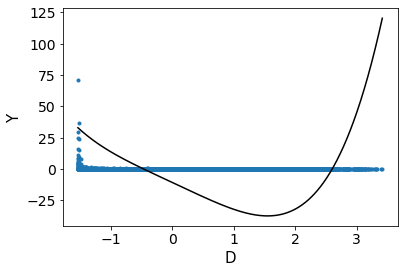

In [372]:
az.plot_pair(df_z[["D", "Y"]].to_dict(orient="list"));
post = quap.sample_posterior(random.PRNGKey(1), params_svi_result, (1000,))
A_map = post["A"].mean()
B0_map = post["B0"].mean()
B1_map = post["B1"].mean()
B2_map = post["B2"].mean()
x = jnp.linspace(df_z.D.min(), df_z.D.max(), 1001)
plt.plot(x, _invariant_dmnlynormd_1(A_map, x, B0_map, B1_map, B2_map), "k");

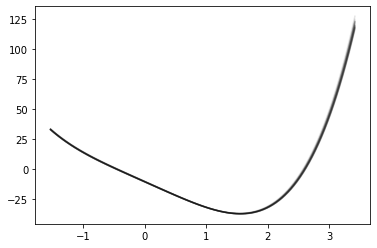

In [378]:
# extract 20 samples from the posterior
post = quap.sample_posterior(key, params_svi_result, (20,))

# display raw data and sample size
# ax = az.plot_pair(df_z[["D", "Y"]].to_dict(orient="list"))
ax.set(
    xlim=(df_z.D.min(), df_z.D.max()),
    # ylim=(df_z.Y.min(), df_z.Y.max()),
)

# plot the lines, with transparency
x = jnp.linspace(df_z.D.min(), df_z.D.max(), 101)
for i in range(20):
    plt.plot(x, _invariant_dmnlynormd_1(post["A"][i], x, post["B0"][i], post["B1"][i], post["B2"][i]), "k", alpha=0.1)


# MCMC

In [427]:
# Now we're going to use MCMC to train on Y with Root as input, instead of D.
def model(root, Y=None): 
    """A model for MCMC"""
    LEN_BALANCES = 3
    A = numpyro.sample("A", dist.LogNormal(4.1, 0.5))
    balances = [numpyro.sample(f"B{i}", dist.Exponential(1)) for i in range(LEN_BALANCES)]
    with numpyro.plate("I", root.shape[0]): 
        I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, root, *balances))
        sigma = numpyro.sample("sigma", dist.Uniform(0, I.std()))
    numpyro.sample("Y", dist.Normal(I, sigma), obs=Y)

In [428]:
nuts_kernel = NUTS(model)

df_z_1000 = df_z.sample(int(1e3))
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, df_z_1000.Root.values, Y=df_z_1000.Y.values)

posterior_samples = mcmc.get_samples()

sample: 100%|█████████████████████████| 4000/4000 [00:59<00:00, 66.73it/s, 127 steps of size 2.72e-02. acc. prob=0.83]


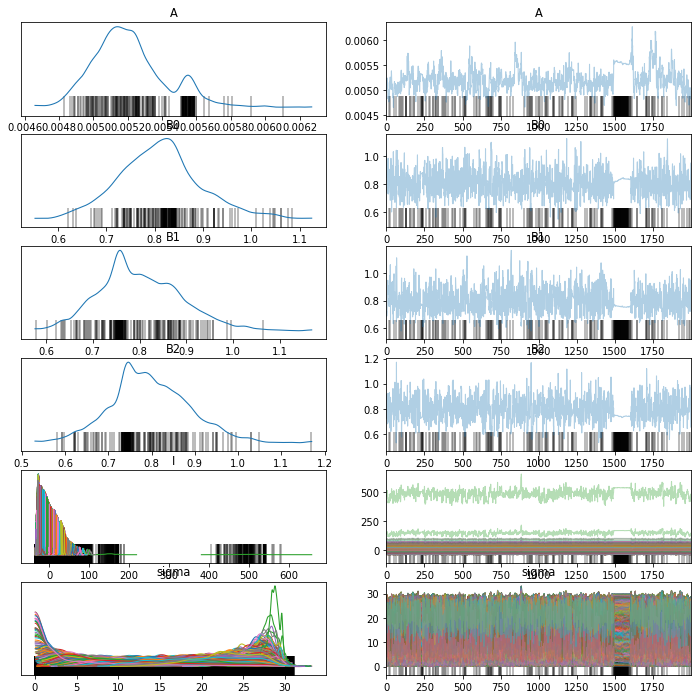

In [429]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

In [431]:
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# New idea lmao: simpler model, that supposes `A` and `balances` are fixed, that _learns_ root by targeting the invariant model to zero. 

In [435]:
df.head()

,A,D,B0,B1,B2,Root,Y,newton_delta,squared_newton_delta
0,2.067659,2.243548e+11,1.475697e+11,8.032713e+10,6.558503e+10,2.924764e+11,1.373189e+34,-6.812162e+10,4.640556e+21
1,1.073261,2.626122e+11,4.022874e+09,2.176361e+09,3.527153e+10,3.586240e+10,-6.780080e+32,2.267498e+11,5.141547e+22
2,2.259081,7.061592e+10,1.231400e+11,1.013308e+10,1.199092e+09,9.825665e+10,7.098000e+31,-2.764073e+10,7.640097e+20
3,2.207330,1.894204e+11,4.743854e+10,1.564121e+11,1.838070e+11,3.841779e+11,8.617764e+34,-1.947575e+11,3.793050e+22
4,1.776335,4.577537e+11,1.195981e+10,1.628059e+11,2.445517e+11,3.899494e+11,-4.993929e+33,6.780430e+10,4.597423e+21


In [467]:
dat = ((df - df.mean()) / df.std()).sample(frac=0.4)
product = partial(reduce, lambda x,y: x * y)

def model(D, Y=None): 
    """A model for MCMC"""
    LEN_BALANCES = 3
    A = numpyro.deterministic("A", dat.A.mean())
    balances = [numpyro.deterministic(f"B{k}", dat[f"B{k}"].mean()) for k in range(LEN_BALANCES)]
    numpyro.sample("sigma", dist.Uniform(0, product(balances)))
    with numpyro.plate("I", D.shape[0]): 
        I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
        
        numpyro.sample("Y", dist.Normal(I, 1), obs=Y)

nuts_kernel = NUTS(model)

# print(dat.D.values.shape, dat.shape[0])
mcmc_rootfinding = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc_rootfinding.run(rng_key, dat.D.values, Y=jnp.zeros(dat.shape[0]))

posterior_samples = mcmc_rootfinding.get_samples()
# posterior_samples

sample: 100%|███████████████████████| 4000/4000 [00:08<00:00, 458.32it/s, 1023 steps of size 2.32e-05. acc. prob=1.00]


/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your d

KeyboardInterrupt: 

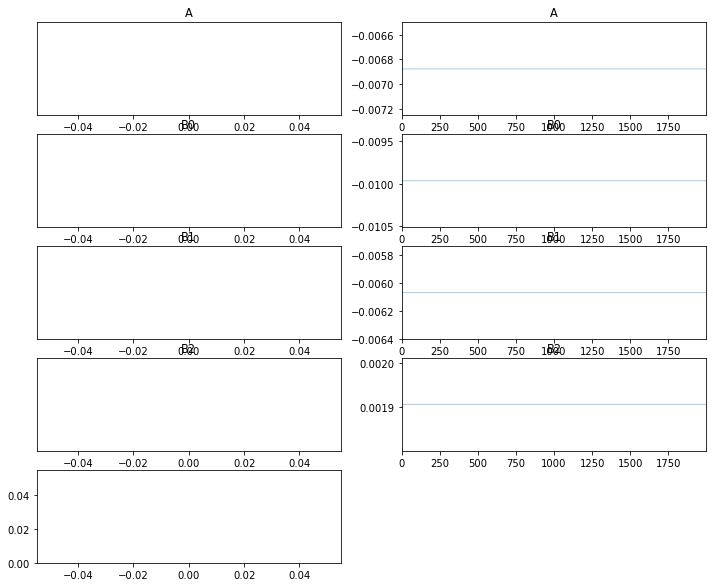

In [466]:
# doesn't seem to want to work. maybe model too simple for mcmc
data_rootfinding = az.from_numpyro(mcmc_rootfinding)
az.plot_trace(data_rootfinding, compact=True);

In [ ]:
dat = (df - df.mean()) / df.std()
product = partial(reduce, lambda x,y: x * y)

def model(D, Y=None): 
    """Training to hit zero"""
    LEN_BALANCES = 3
    A = numpyro.deterministic("A", dat.A.mean())
    balances = [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]

    I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
        
    numpyro.sample("Y", dist.Normal(I, 1), obs=Y)

quap = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    quap,
    optim.Adam(1),
    Trace_ELBO(),
    D=dat.D.values,
    Y=jnp.zeros(dat.shape[0]),
)
svi_result = svi.run(key, 2000)

samples = quap.sample_posterior(key, svi_result.params, (1000,))
print_summary({key: value for key,value in samples.items() if key != "I"}, 0.89, False)

100%|████████| 2000/2000 [00:04<00:00, 465.54it/s, init loss: 3207804747776.0000, avg. loss [1901-2000]: 3833878.5000]


In [ ]:
@interact(D=FloatSlider(min=0, max=dat.D.min()))
def model_kde(D: float):
    az.plot_kde(_invariant_dmnlynormd_1(samples["A"], D, samples["B0"], samples["B1"], samples["B2"]), label=f"I({D}) < epsilon")


In [ ]:
samples["I"].mean()

In [ ]:
az.plot_kde(samples["I"])

# Playing with autodiff

In [348]:
grad_inv = grad(_invariant_dmnlynormd_1)
grad_inv(A_map, df.D.mean(), B0_map, B1_map, B2_map)

DeviceArray(1.6804887e+14, dtype=float32)

In [351]:
grad_inv(A_map, df.D.mean(), B0_map, B1_map, B2_map)

DeviceArray(1.6804887e+14, dtype=float32)

In [366]:
# the gradient of the scalar field
jnp.stack(list(map(lambda f: f(A_map, df_z.D.mean(), B0_map, B1_map, B2_map), [grad(_invariant_dmnlynormd_1, argnums=i) for i in range(4)])))


DeviceArray([-1900.375  ,   -22.97826,    -4.02174,    -4.02174], dtype=float32)

# Getting eyes on basic distributions

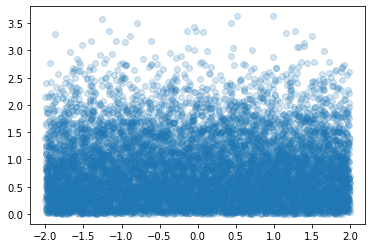

In [396]:
num_samples = 10000
distribution = dist.Normal(3e10, 1e10)
distribution2 = dist.Normal(4e10, 2e10)
exponential = dist.Exponential(5e-2)
lognormal = dist.LogNormal(1, 0.5)
weight = 0.7
poisson = dist.Poisson(7)
halfcauchy = dist.HalfCauchy(100)
halfnormal = dist.HalfNormal(1, 1)

# sample = weight * distribution.sample(random.PRNGKey(0), (num_samples,)) + (1 - weight) * distribution2.sample(random.PRNGKey(0), (num_samples,))
sample = exponential.sample(random.PRNGKey(0), (num_samples,)) + lognormal.sample(random.PRNGKey(0), (num_samples,))
sample = halfnormal.sample(key, (num_samples,)) 

plt.scatter(
    jnp.linspace(start=-2, stop=2, num=num_samples),
    sample,
    alpha=0.2
);

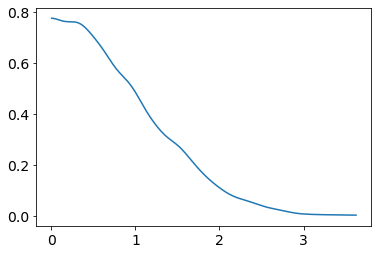

In [397]:
az.plot_kde(sample);

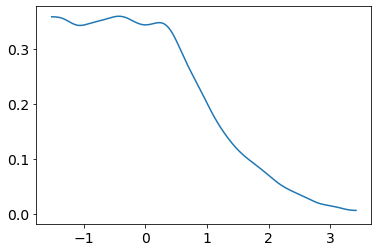

In [383]:
az.plot_kde(df_z.B1);

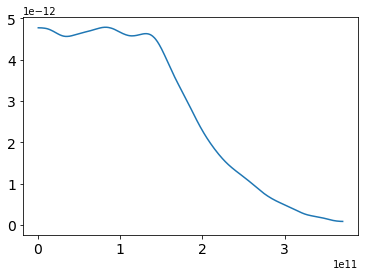

In [318]:
az.plot_kde(df.B1);